_____
# About This Notebook
____
### NLP Preprocessing and EDA (All Data Version with no down or up sampling)
______

This notebook is one of two notebooks that pertain to NLP preprocessing and EDA. This notebook include all data from the original cleaned dataset. It includes less EDA than the balanced version as this version is dealing with a heavier, imbalanced dataset. This dataset is thus harder to push through timely functions/models.

This notebook takes two different CSV's: `002_white_clean.csv` and `002_red_clean.csv.` The notebooks are concatenated into a df called `wine`. It then follows the following steps in the preprocessing and exploratory data analysis process to export a df called wine_slim that includes cleaned and preprocessed data with only the feature columns necessary for modeling.

______
**CONTENTS**

* [Preprocessing](#Preprocessing)
    * [Stop Words](#stops)
    * [Target Label Encoding](#encode)
    * [Spacy NLP](#spacy)
    * [Word Clouds](#cloud)
_____

_____
## Imports
_____

In [75]:
# Standard Libraries
import pandas as pd
import numpy as np
import pickle as pkl

import matplotlib.pyplot as plt
import seaborn as sns

# NLTK Libraries
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize, RegexpTokenizer
from nltk.corpus import stopwords

# SKLearn Libraries
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction import text
from sklearn.preprocessing import LabelEncoder

# Other NLP Libaries
import re # regex
import string

# Spacy Imports
import spacy
from spacy.lang.en.stop_words import STOP_WORDS
from spacy import displacy
import scattertext as st
from scattertext import CorpusFromPandas, produce_scattertext_explorer
import spacy_streamlit
import amrlib


# imports related to deploying Spacy Scattertext within notebook and local browser.
import os, pkgutil, json, urllib
from urllib.request import urlopen
from IPython.display import IFrame
from IPython.core.display import display, HTML
from pathlib import Path


# Imports related to creating word clouds
from os import path
from PIL import Image
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator



import pickle

____
## Read in Data
____

In [76]:
#### Importing White Wine Grapes ####

## url to read data from Github to Google Colab ##
# url1 = 'copied_raw_GH_link'

grapes_white = pd.read_csv('../data/002_white_cleaned.csv')

#### Importing Red Wine Grapes ####

## url to read data from Github to Google Colab ## 
# url2 = 'copied_raw_GH_link'

grapes_red = pd.read_csv('../data/002_red_cleaned.csv')

In [77]:
# Concatenating the two imports
wine = pd.concat([grapes_white, grapes_red])

# resetting index of new df
wine.reset_index(drop = True, inplace = True)

wine.head(1)

,winery,varietal,designation,country,province,description,region_1,region_2,points,price,taster_name,title,vareital,color
0,St. Julian,Riesling,Reserve Late Harvest,US,Michigan,"Pineapple rind, lemon pith and orange blossom ...",Lake Michigan Shore,unknown,87.0,13.0,Alexander Peartree,St. Julian 2013 Reserve Late Harvest Riesling ...,Riesling,white


<a id='Preprocessing'></a>
_______
# Preprocessing
______

______
**Cleaning Symbols/Numbers/Capital Letters**


* This function takes in a df label and a series/column label, eliminates numbers, strips white space, lowercases characters, sets changes to original series/column. 
* I didn't want to remove punctuation yet because I believe the Spacy library accounts for punctuation when the model analyzes the corpus. I may be wrong but that is my understanding. 

In [78]:
def rmv_num_sym(df, series_label):
    
    # getting rid of numbers
    df[series_label] = df[series_label].str.replace('\d+', ' ')
    
    # getting rid of commas
    df[series_label]= df[series_label].str.replace(',', '')
     
    # stripping white space
    df[series_label]= df[series_label].str.strip(' ')
    
    # lowercase all remaining characters
    df[series_label] = df[series_label].str.lower()
    
    # removing punctuation
    tokenizer = RegexpTokenizer(r'\w+')
    df[series_label] = df[series_label].apply(tokenizer.tokenize)
   
    # make sure to reassign df to this function to set changes to permanent. 
    return df

<a id='stops'></a>
______
## Stop Words
______

* Here I will be pulling in the `final_stops` list from `002_nlp_eda_downsample` notebook via pickle. I will use this list imported as `imported_stops` to remove stop words from this corpus. 

______
### Importing Custom Stops List as 'imported_stops'
______

In [79]:
with open('../07_pickle_files/custom_stops.pkl', 'rb') as f:
    imported_stops = pkl.load(f)
    
len(imported_stops)

22402

___
### Checking Amount of Stop Words
_____

In [80]:
def stop_words_checker(df, series_label, stop_words):
    
    # Function that checks to see how many of stop words are in a series
    
    count = 0
    total_words = 0
    
    for post in df[series_label]:
        for word in post.split():
            if word in stop_words:
                count += 1
    
    for posts in df[series_label]:
        for word in post.split():
            total_words += 1
       
    print(f'There are {count} stop words in this corpus.')
    print(f'Out of {total_words} total words in corpus.')
    print(f'Stop words account for {round((count / total_words * 100), ndigits = 2)}% of all words in corpus.')
    

In [81]:
stop_words_checker(wine, 'description', imported_stops)

There are 1708824 stop words in this corpus.
Out of 2799042 total words in corpus.
Stop words account for 61.05% of all words in corpus.


_____
### Removing Stops
_____

In [82]:
def remove_stop_words(df, series_label, stop_words):
    
    # A function that removes stop words from corpus
    
    df['stop_out'] = df[series_label].apply(lambda x: ' '.join([word for word in x.split() if word not in stop_words]))
    df[series_label] = df['stop_out']
    df.drop(columns = ['stop_out'], inplace = True)
    df.reset_index(drop = True, inplace = True)
    
    return df

In [83]:
# cleaning stop words
wine = remove_stop_words(wine, 'description', imported_stops)

In [84]:
# checking to see if stop words are gone
stop_words_checker(wine, 'description', imported_stops)

There are 0 stop words in this corpus.
Out of 1178544 total words in corpus.
Stop words account for 0.0% of all words in corpus.


____
**Slicing DF to include only columns I will use in modeling**

In [85]:
# create a sliced df containing only the description column and varietal
wine_slim = wine.copy()[['varietal', 'description', 'color']]
wine_slim

,varietal,description,color
0,Riesling,"Pineapple rind, lemon pith blossom start aroma...",white
1,Gewurztraminer,This restrained profusion. Balanced firm textu...,white
2,Gewurztraminer,Savory dried thyme accent sunnier preserved br...,white
3,Gewurztraminer,"This wine, spicy, tight, taut texture strongly...",white
4,Chardonnay,"Building 150 tradition, trends leaner style, C...",white
...,...,...,...
73654,Tempranillo,"Lightly baked attention leather, mild notes, r...",red
73655,Cabernet Sauvignon,This Cabernet Sauvignon-Merlot Cabernet Franc ...,red
73656,Pinot Noir,"Fresh fruity, acidity. It age, hinting toasty ...",red
73657,Cabernet Sauvignon,"A cherry, cranberry clove cherry, anisette, es...",red


____
### Combining Features
____

Here I am combining the color and description columns in order to recreate the human experience of seeing a wines color to help in determining what wine it is. 


In [86]:
wine_slim['descrption'] = wine_slim['description'] + ' ' + wine_slim['color']

<a id='encode'></a>
____
## Label Encoding
____

In [87]:
def encode_workflow(target_series):
    
    original_targets = target_series.value_counts().index
    
    # Instantiate LabelEncoder(), fit label encoder and return encoded labels
    encoded_targets = LabelEncoder().fit_transform(target_series)
    
    # create a df of target labels
    encoded = pd.DataFrame(encoded_targets) 
    
    # create a df that contains only the encoded df's value_counts()
    encoded = encoded[0].value_counts()
    
    # reset the index so the class labels are no longer the index
    encoded = encoded.reset_index()
    
    # rename columns for clarity
    encoded.rename(columns = {'index': 'encoded_labels', 0: 'count'}, inplace = True)
    
    # creating a dictionary of original string labels for target variables
    targ_dict = dict(zip(encoded['count'], original_targets))
                     
    # mapping original target names to encoded                 
    encoded['target_label'] = encoded['count'].map(targ_dict)
                     
    # reordering columns
    encoded = encoded.loc[ :, ['target_label', 'encoded_labels', 'count']]
                     
    # setting target labels as index
    encoded = encoded.set_index('target_label')
    
    # sorting in numerical order based on encoded labels
    encoded = pd.DataFrame(encoded['encoded_labels'].sort_values())
    
    
                     
    # printing out df. Transposing to reduce length in workbook
    return encoded

In [88]:
# Creating label_counts df by calling the encode_workflow custom function
label_counts = encode_workflow(wine_slim['varietal'])


# # Transposing it to shorten workbook
label_counts.to_csv('../data/encoded_target_labels.csv')

label_counts.T

target_label,Albarino,Cabernet Sauvignon,Chardonnay,Chenin Blanc,Garganega,Gewurztraminer,Glera,Grenache,Gruner Veltliner,Malbec,...,Nebbiolo,Pinot Grigio,Pinot Noir,Riesling,Sangiovese,Sauvignon Blanc,Syrah,Tempranillo,Viognier,Zinfandel
encoded_labels,0,1,2,3,4,5,6,7,8,9,...,11,12,13,14,15,16,17,18,19,20


_____
### Combining Feature Columns
_____

To more adequately simulate a real blind tasting I am combining the color and description columns so that color can be added as a feature. In a real blind tasting the average person, upon sight, would immediately know whether a wine was red or white. 

In [104]:
wine_slim['description'] = wine_slim['description'] + ' ' + wine_slim['color']

<a id='spacy'></a>
_________
# Spacy NLP Processing

* loading a pre-configured Spacy Pipeline that will take in text, tokenize it, tag it, parse it and apply named entity recognition. It then returns a 'doc' that I will populate in a new column called 'parsed'.

This is an example of what Spacy is doing under the hood: 

![alt text](https://spacy.io/pipeline-fde48da9b43661abcdf62ab70a546d71.svg)

graphic from www.Spacy.io documentation

**Useful Spacy Methods**
* token.lemma_
* token.text
* token.pos_
* token.is_stop
_______

_____
## Loading in Pre-configured Spacy Model.
_____

In [90]:
nlp = spacy.load('en_core_web_sm')

**Applying Spacy pre-trained NLP model to Corpora**
THIS TAKES A BIT OF TIME TO LOAD

In [92]:
# applying the spacy model to preprocessed text.
wine_slim['parsed'] = wine_slim['description'].apply(nlp)

In [107]:
wine_slim['parsed'][0]

Pineapple rind, lemon pith blossom start aromas. The bit opulent, honey-drizzled guava giving slightly astringent, finish. white

______
# Saving Pre-Processed wine_df to csv

In [108]:
wine_slim.to_csv('../data/003_preprocessed_all_data.csv', index = False)

<a id='cloud'></a>
__________
# Word Clouds
__________
* Just for fun to add entertaining graphics to my presentation. 
* Not for use with EDA or to present serious information.
* The idea for this was adapted from this site.
[word cloud in image](#'https://towardsdatascience.com/generate-word-clouds-of-any-shape-in-python-e87f265f6352')

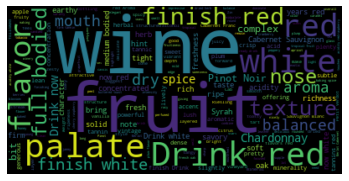

In [95]:
text = ' '.join(desc for desc in wine_slim['description'])


wordcl = WordCloud().generate(text)
plt.imshow(wordcl, interpolation = 'bilinear')
plt.axis('off')
plt.show()

In [96]:
mask = np.array(Image.open('../05_presentation_media/wine_sillouettes.png'))

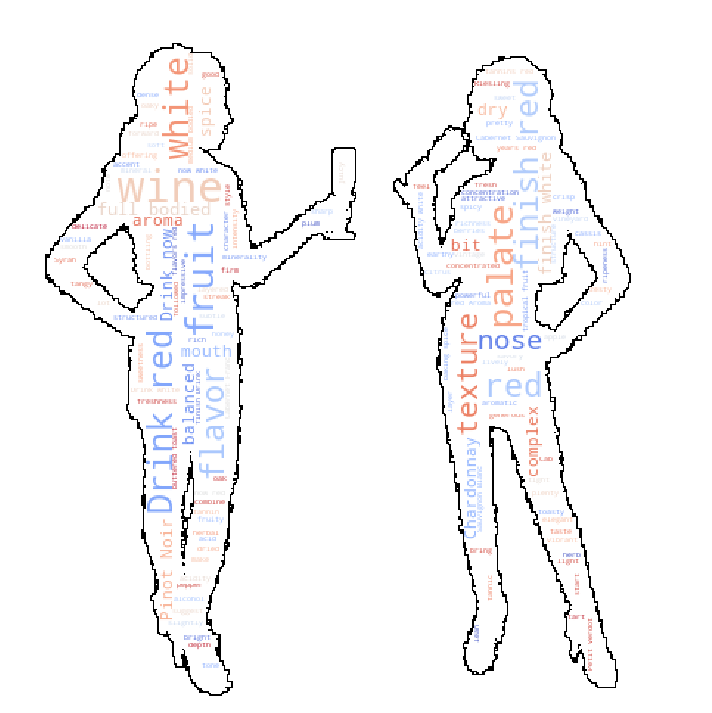

In [97]:
wc = WordCloud(background_color='white', mask = mask, mode = 'RGB', 
              width = 1000, max_words = 200, height = 1000, 
              random_state = 42, contour_width = 1,
              contour_color = 'black', 
               colormap = 'coolwarm')
wc.generate(text)
plt.figure(figsize = (10,10))
plt.imshow(wc, interpolation='nearest')
plt.tight_layout(pad=0)
plt.axis('off')
plt.show()

In [98]:
wc.to_file('../05_presentation_media/wine_girls.png')

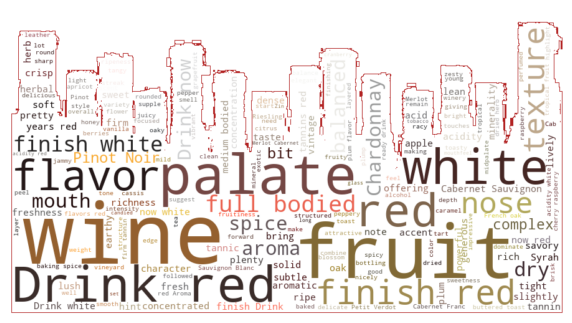

In [99]:
bottles = np.array(Image.open('../05_presentation_media/bottles.png'))
wc_bottles = WordCloud(background_color="white", mask=bottles,
              contour_width=1, contour_color='firebrick')
wc_bottles.generate(text)
image_colors = ImageColorGenerator(bottles)
wc_bottles.recolor(color_func=image_colors)
plt.figure(figsize=(10,10))
plt.imshow(wc_bottles, interpolation='bilinear')
plt.axis('off')
plt.show()

In [100]:
wc_bottles.to_file('../05_presentation_media/wine_bottles.png')

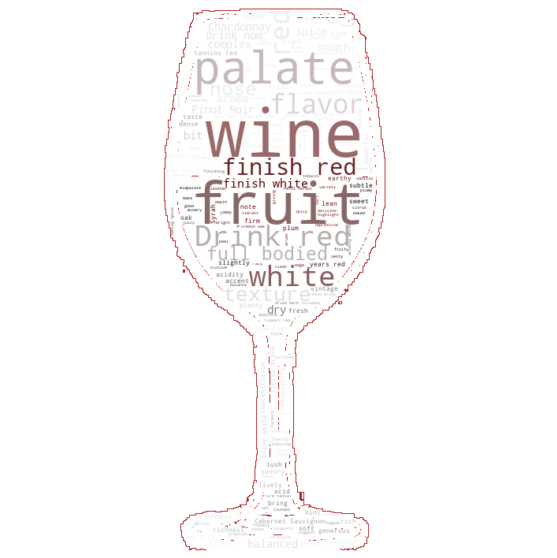

In [101]:
glass = np.array(Image.open('../05_presentation_media/wine_glass.jpeg'))
wc_glass = WordCloud(background_color="white", mask=glass,
              contour_width=1, contour_color='firebrick')
wc_glass.generate(text)
image_colors = ImageColorGenerator(glass)
wc_glass.recolor(color_func=image_colors)
plt.figure(figsize=(10,10))
plt.imshow(wc_glass, interpolation='bilinear')
plt.axis('off')
plt.show()

In [102]:
wc_glass.to_file('../05_presentation_media/wc_wine_glass.png')

_____
# Next Steps
_____

* This notebook sends out a csv that has been completely preprocess with the full data set including it's class imbalances. It will now be used in all modeling notebooks where all data will be used. 